# Homework: Search Evaluation


## Required libraries


In [1]:
# !pip install -U minsearch qdrant_client

## Evaluation data

We will use the same dataset generated in the videos.


In [2]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
ground_truth = df_ground_truth.to_dict(orient='records')

In [3]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [4]:
df_ground_truth.head(3)

,question,course,document
0,When does the course begin?,data-engineering-zoomcamp,c02e79ef
1,How can I get the course schedule?,data-engineering-zoomcamp,c02e79ef
2,What is the link for course registration?,data-engineering-zoomcamp,c02e79ef


In [5]:
ground_truth[0]

{'question': 'When does the course begin?',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

In [6]:
# Code for evaluating retrieval
from tqdm.auto import tqdm

def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

# Q1. Minsearch Text

Now let's evaluate our usual minsearch approach, but tweak the parameters. Let's use the following boosting params:


In [7]:
import minsearch

In [8]:
minsearch.__version__

'0.0.4'

In [9]:
index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course", "id"]
)

index.fit(documents)

In [10]:
def minsearch_search(query, course):
    boost = {'question': 1.5, 'section': 0.1}

    results = index.search(
        query=query,
        filter_dict={'course': course},
        boost_dict=boost,
        num_results=5
    )

    return results

In [11]:
evaluate(ground_truth, lambda q: minsearch_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.848714069591528, 'mrr': 0.7288235717887772}

# Embeddings


In [12]:
from minsearch import VectorSearch

In [13]:
# TF-IDF and Singular Value Decomposition to create embeddings from text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

In [14]:
texts = []

for doc in documents:
    t = doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [15]:
texts[:5]

['Course - When will the course start?',
 'Course - What are the prerequisites for this course?',
 'Course - Can I still join the course after the start date?',
 'Course - I have registered for the Data Engineering Bootcamp. When can I expect to receive the confirmation email?',
 'Course - What can I do before the course starts?']

In [16]:
X[0]

array([ 0.20189188, -0.19028114, -0.10261914,  0.16435334, -0.14004852,
       -0.19928493,  0.0326298 ,  0.03152187,  0.11015991, -0.25056714,
       -0.2297715 , -0.08275686,  0.0107985 ,  0.01912367, -0.03904959,
        0.04858485, -0.03590806,  0.00200877, -0.20405168, -0.01187959,
        0.07217801,  0.21314061,  0.0352884 ,  0.09334844,  0.00800627,
        0.02730576, -0.05747045, -0.08794382,  0.04599191,  0.09568683,
        0.10378307, -0.12981451, -0.03935688,  0.03076194,  0.02946738,
       -0.02071025,  0.09501766,  0.05341492, -0.02582382,  0.08743149,
       -0.03647388, -0.168532  , -0.08957893,  0.03547496,  0.11095151,
        0.13033041, -0.07362053,  0.13634367,  0.09826041, -0.05042163,
        0.10989516,  0.00500543, -0.06848177,  0.0502295 ,  0.06014098,
        0.11383368,  0.05322441, -0.02371468, -0.0975518 ,  0.02646635,
        0.00609063, -0.00198324,  0.11985142,  0.08729537,  0.08522016,
        0.01295767,  0.03040857,  0.04797036, -0.00390723, -0.06

In [17]:
len(X[0])

128

# Q2. Vector search for question

Index these embeddings with minsearch


In [18]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [19]:
def minsearch_vector_search(vector, course):
    return vindex.search(
        vector,
        filter_dict={'course': course},
        num_results=5
    )

def vector_search_for_eval(q):
    question = q['question']
    course = q['course']

    # Transform the query question into a vector
    v_q = pipeline.transform([question])[0]

    # Perform the vector search
    return minsearch_vector_search(v_q, course)

In [20]:
# Evaluate the vector search function
evaluate(ground_truth, vector_search_for_eval)

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.48173762697212014, 'mrr': 0.3572833369353793}

# Q.3 Vector search for question and answer

We only used question in Q2. We can use both question and answer


In [21]:
texts = []

for doc in documents:
    t = doc['question'] + ' ' + doc['text']
    texts.append(t)

In [22]:
pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [23]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [24]:
# Evaluate the vector search function
evaluate(ground_truth, vector_search_for_eval)

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.8210503566025502, 'mrr': 0.6717347453353508}

# Q.4 Qdrant

Now let's evaluate the following settings in Qdrant:

    text = doc['question'] + ' ' + doc['text']
    model_handle = "jinaai/jina-embeddings-v2-small-en"
    limit = 5


In [25]:
from qdrant_client import QdrantClient, models

In [26]:
qd_client = QdrantClient("http://localhost:6333")

In [27]:
EMBEDDING_DIMENSIONALITY = 512
model_handle = "jinaai/jina-embeddings-v2-small-en"

In [28]:
collection_name = "zoomcamp-faq"

In [29]:
qd_client.delete_collection(collection_name=collection_name)

True

In [30]:
qd_client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY,
        distance=models.Distance.COSINE
    )
)

True

In [31]:
qd_client.create_payload_index(
    collection_name=collection_name,
    field_name="course",
    field_schema="keyword"
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [32]:
points = []

for i, doc in enumerate(documents):
    text = doc['question'] + ' ' + doc['text']
    vector = models.Document(text=text, model=model_handle)
    point = models.PointStruct(
        id=i,
        vector=vector,
        payload=doc
    )
    points.append(point)

In [33]:
qd_client.upsert(
    collection_name=collection_name,
    points=points
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

In [34]:
def qdrant_vector_search(question, course):
    
    course = course
    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        query_filter=models.Filter( 
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course)
                )
            ]
        ),
        limit=5,
        with_payload=True
    )
    
    results = []
    
    for point in query_points.points:
        results.append(point.payload)
    
    return results

In [35]:
evaluate(ground_truth, lambda q: qdrant_vector_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.9299762264966501, 'mrr': 0.8517722066133576}

# Q5. Cosine similarity

Cosine similarity is a dot product between two normalized vectors. In geometrical sense, it's the cosine of the angle between the vectors.


In [36]:
import numpy as np

In [37]:
def cosine(u, v):
    u_norm = np.sqrt(u.dot(u))
    v_norm = np.sqrt(v.dot(v))
    return u.dot(v) / (u_norm * v_norm)

Use this function to compute the A->Q->A cosine similarity. Use the results from our gpt-4o-mini evaluations:


In [38]:
results_url = url_prefix + 'rag_evaluation/data/results-gpt4o-mini.csv'
df_results = pd.read_csv(results_url)

In [39]:
df_results.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [40]:
# Embeddings in simple way
pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)

In [41]:
# fit the vectorizer on all the text data
pipeline.fit(df_results.answer_llm + ' ' + df_results.answer_orig + ' ' + df_results.question)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(min_df=3)),
                ('truncatedsvd',
                 TruncatedSVD(n_components=128, random_state=1))])

In [42]:
# use the transform method of the piple to create the embeddings and calculate the cosine similarity between each pair
def calculate_similarity(row):
    v_llm = pipeline.transform([row['answer_llm']])[0]
    v_orig = pipeline.transform([row['answer_orig']])[0]
    return cosine(v_llm, v_orig)

df_results['cosine_similarity'] = df_results.apply(calculate_similarity, axis=1)

In [43]:
df_results.cosine_similarity.mean()

np.float64(0.8415841233490402)

Text(0.5, 9.444444444444438, "A->Q->A' Cosine Similarity")

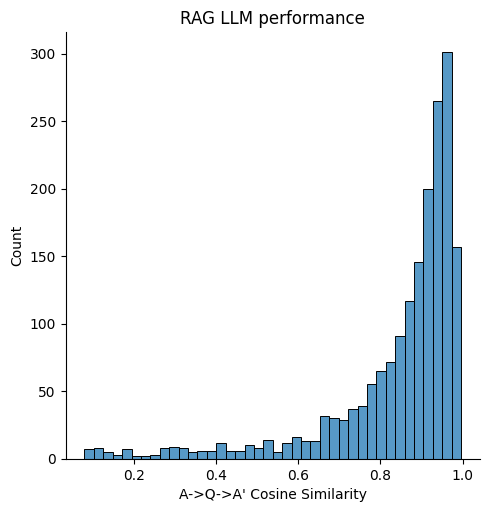

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(df_results, x='cosine_similarity')
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")

# Q6. Rouge

An alternative way to see how two texts are similar is ROUGE.<br>
This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.<br>
It can give a more nuanced view of text similarity than just cosine similarity alone.<br>
We don't need to implement it ourselves, there's a python package for it:


In [45]:
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [46]:
from rouge import Rouge
rouge_scorer = Rouge()

r = df_results.iloc[10]
scores = rouge_scorer.get_scores(r.answer_llm, r.answer_orig)[0]
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

In [47]:
# Let's compute it for the pairs in the entire dataframe. What's the average Rouge-1 F1?
df_results['rouge_1_f1'] = df_results.apply(
    lambda row: rouge_scorer.get_scores(row['answer_llm'], row['answer_orig'])[0]['rouge-1']['f'], axis=1
)

In [48]:
df_results['rouge_1_f1'].mean()

np.float64(0.3516946452113943)